**Part 2: Preprocessing and Exploration
Task 2.1: Text Cleaning**<br>
 Analysis     : My goal is to clean the lyrics without removing too much, so that I can retain as much of the original meaning and expression as possible.<br>
                  - Since lyrics use artistic language and emotion, I want to avoid over-cleaning. Performing the following cleaning:-<br>
                  - Remove duplicated tokens, to prevent repetitive noise [tokens included in repetitive chorus].<br>
                  - Remove numbers and filler/vocalization words commonly used in songs (e.g. yeah, yeh, ok, ohh, ahhh).<br>
                  - Keep negation words and important verbs, as they carry sentiment and meaning.<br>
                  - Lightly handle punctuation and stopwords, only removing those clearly adding noise while keeping stylistic elements.<br>
                  - Use various Python tools (regular expressions, NLTK, etc.) to help visualize and decide what to remove or keep.<br>
                  - Overall, my aim is to keep valuable tokens that capture the expressive nature of lyrics, while removing obvious noise.


In [8]:
import re
import pyodbc
import json
from nltk.tokenize import RegexpTokenizer
import contractions
from nltk.corpus import stopwords, wordnet
import regex as re  # regex module for Unicode support

def connect_db():
    """
    Connect to the SQL Server database and return the connection object.
    """
    # Connect to local SQL Express instance with TextMiningHA database
    conn = pyodbc.connect(
        r'DRIVER={ODBC Driver 17 for SQL Server};'
        r'SERVER=IVAN_PC\SQLEXPRESS;'
        r'DATABASE=TextMiningHA;'
        r'Trusted_Connection=yes;'
    )

    return conn

def looks_like_a_word(token):
    """
    True if token looks like a real word (letters only from any language, length >=3)
    """
    # Uses regex Unicode property to match letters only
    return bool(re.fullmatch(r'\p{L}{3,}', token))

def vocabulary_POS(tokens, pos_prefixes=('NN', 'VB', 'JJ')):
    """
    Keep tokens that are nouns, verbs, or adjectives (based on POS tag prefix).
    """
    tagged = pos_tag(tokens)  # POS tag all tokens
    return [word for word, tag in tagged if tag.startswith(pos_prefixes)]

def tokenize_all_lyrics():
    """
    Basic tokenization: fetch lyrics from DB, expand contractions,
    lowercase, tokenize, and save raw tokens to DB.
    """
    conn = connect_db()
    cursor = conn.cursor()

    # Fetch all songs
    cursor.execute("SELECT song_id, name, lyrics FROM songs ORDER BY song_id")
    rows = cursor.fetchall()

    tokenizer = RegexpTokenizer(r"\w+(?:'\w+)?")  # Tokenizer keeping contractions

    for idx, (song_id, name, lyrics) in enumerate(rows, start=1):
        # Replace line breaks with space
        basic_clean_lyrics = (lyrics or "").replace('\r', ' ').replace('\n', ' ')

        # Split repeated phrases by multiple spaces
        phrases = [p.strip() for p in basic_clean_lyrics.split('    ') if p.strip()]
        unique_phrases = list(dict.fromkeys(phrases))  # remove duplicate phrases
        clean_double_lyrics = '    '.join(unique_phrases)

        # Expand contractions and lowercase
        expanded_lyrics = contractions.fix(clean_double_lyrics).lower()

        # Tokenize lyrics
        tokens = tokenizer.tokenize(expanded_lyrics)

        # Save raw tokenized lyrics to DB
        cursor.execute(
            "UPDATE songs SET tokenised = ? WHERE song_id = ?",
            json.dumps(tokens, ensure_ascii=False),
            song_id
        )
    conn.commit()
    conn.close()
    print("Basic tokenization process ready filled in tokenised column songsdb.")


def clean_lyrics_tokens(start_row, end_row, show_output=1):
    """
    Domain-specific cleaning: remove stopwords, lyric-specific noise words,
    numbers, very short words, repeated characters, then save cleaned tokens to DB.
    No lemmatization and no POS tagging.
    """
    conn = connect_db()
    cursor = conn.cursor()

    # Fetch songs from DB
    cursor.execute("SELECT song_id, name, lyrics, tokenised FROM songs ORDER BY song_id")
    rows = cursor.fetchall()
    selected_rows = rows[start_row - 1:end_row]  # select subset of rows

    # Define stopwords plus lyric-specific noise words
    base_stopwords = set(stopwords.words('english'))
    base_stopwords |= {'intro','aah','aahh','cuz','yeah','yea','hey','til',
                       'chorus','ohoho','oho','ooh','ohh','oohh','whoa','aawaah'}

    # Keep important negations & pronouns
    keep_words = {'not','no','never','nor','but','if','you','i','he','she','they','our','my','us'}
    base_stopwords -= keep_words  # remove them from stopwords

    for idx, (song_id, name, lyrics, tokenised_json) in enumerate(selected_rows, start=start_row):
        ordered_lyrics = (lyrics or "").replace('\r', ' ').replace('\n', ' ')
        tokens = json.loads(tokenised_json or "[]")  # parse JSON token list

        # Map auxiliary verbs to "be"
        aux_map = {'is':'be', 'are':'be', 'was':'be', 'were':'be', 'am':'be', 'been':'be', 'being':'be'}
        tokens = [aux_map.get(t.lower(), t) for t in tokens]

        cleaned_tokens = []
        for t in tokens:
            t = re.sub(r"'s$", '', t)                        # Remove trailing "'s"
            if t in keep_words:
                cleaned_tokens.append(t)                     # Keep important pronouns
            elif t in base_stopwords:
                continue                                     # Remove stopwords
            elif any(char.isdigit() for char in t):
                continue                                     # Remove numbers
            elif len(t) <= 2:
                continue                                     # Remove very short tokens
            elif re.search(r'(.)\1\1', t):
                continue                                     # Remove repeated characters
            elif not looks_like_a_word(t):
                continue                                     # Remove invalid tokens
            else:
                cleaned_tokens.append(t.lower())            # Keep lowercase token

        # Save cleaned tokens to DB
        cursor.execute(
            "UPDATE songs SET cleanTokens = ? WHERE song_id = ?",
            json.dumps(cleaned_tokens, ensure_ascii=False),
            song_id
        )

        # Optional debug output
        if show_output == 1:
            print(f"--- Song {idx}: {name} ---")
            print("Original lyrics:")
            print(ordered_lyrics)
            print("\nTokenized lyrics:")
            print(tokens)
            print("\n" + "-" * 100 + "\n")
            print("Polished tokens:")
            print(cleaned_tokens)
            print("\n" + "." * 100 + "\n")

    print("Polished tokens process ready filled in cleanTokens column songsdb.")
    conn.commit()
    conn.close()



# The following functions populate the 'tokenised' and 'cleanTokens' columns in the database:
# - 'tokenised' stores the raw tokenized lyrics.
# - 'cleanTokens' stores the cleaned, processed tokens ready for NLP analysis.


#Tokenize all lyrics (raw tokens)
tokenize_all_lyrics()

# Clean tokenized lyrics for NLP (removes stopwords, noise, short words, etc.)
clean_lyrics_tokens(1, 1600, show_output=0)  # Set show_output=1 to view original, tokenized, and cleaned lyrics


Basic tokenization process ready filled in tokenised column songsdb.
Polished tokens process ready filled in cleanTokens column songsdb.


**Task 2.2: Exploratory Analysis <br> PART1**<br>Using functions such as fetch_tokenized_lyrics(), plot_wordcloud(tokens), plot_top_word_frequencies(tokens), print(vocabulary_diversity(tokens)), plot_pos_distribution(tokens, top_n=20), and fetch_cleaned_tokens(), I explored the dataset in several ways. These tools helped me generate word clouds to visualize frequent terms, plot word frequency distributions, and measure vocabulary diversity to detect repetition or variation. Finally, part-of-speech tagging allowed me to analyze grammatical roles and compare distributions before and after cleaning for a clearer understanding of the dataset’s structure.


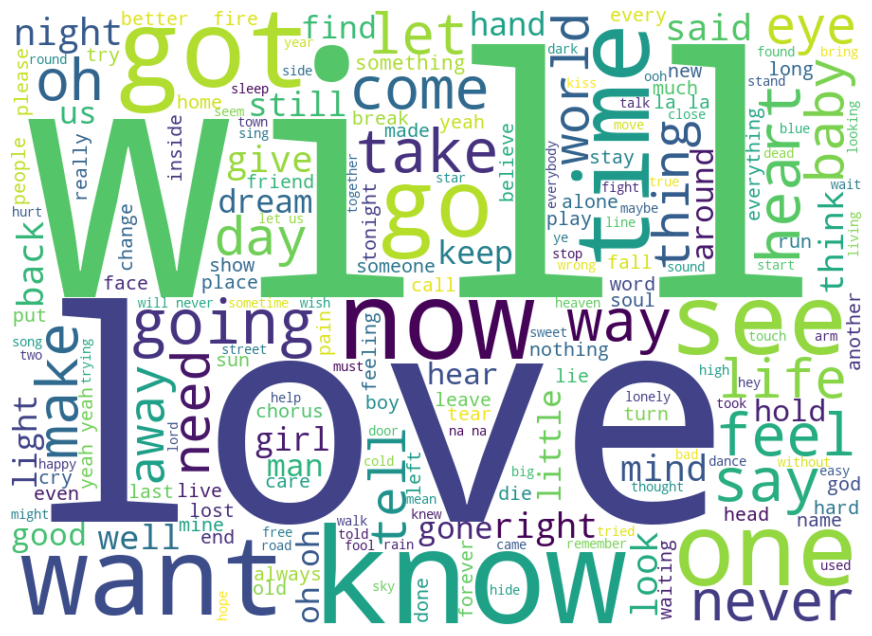

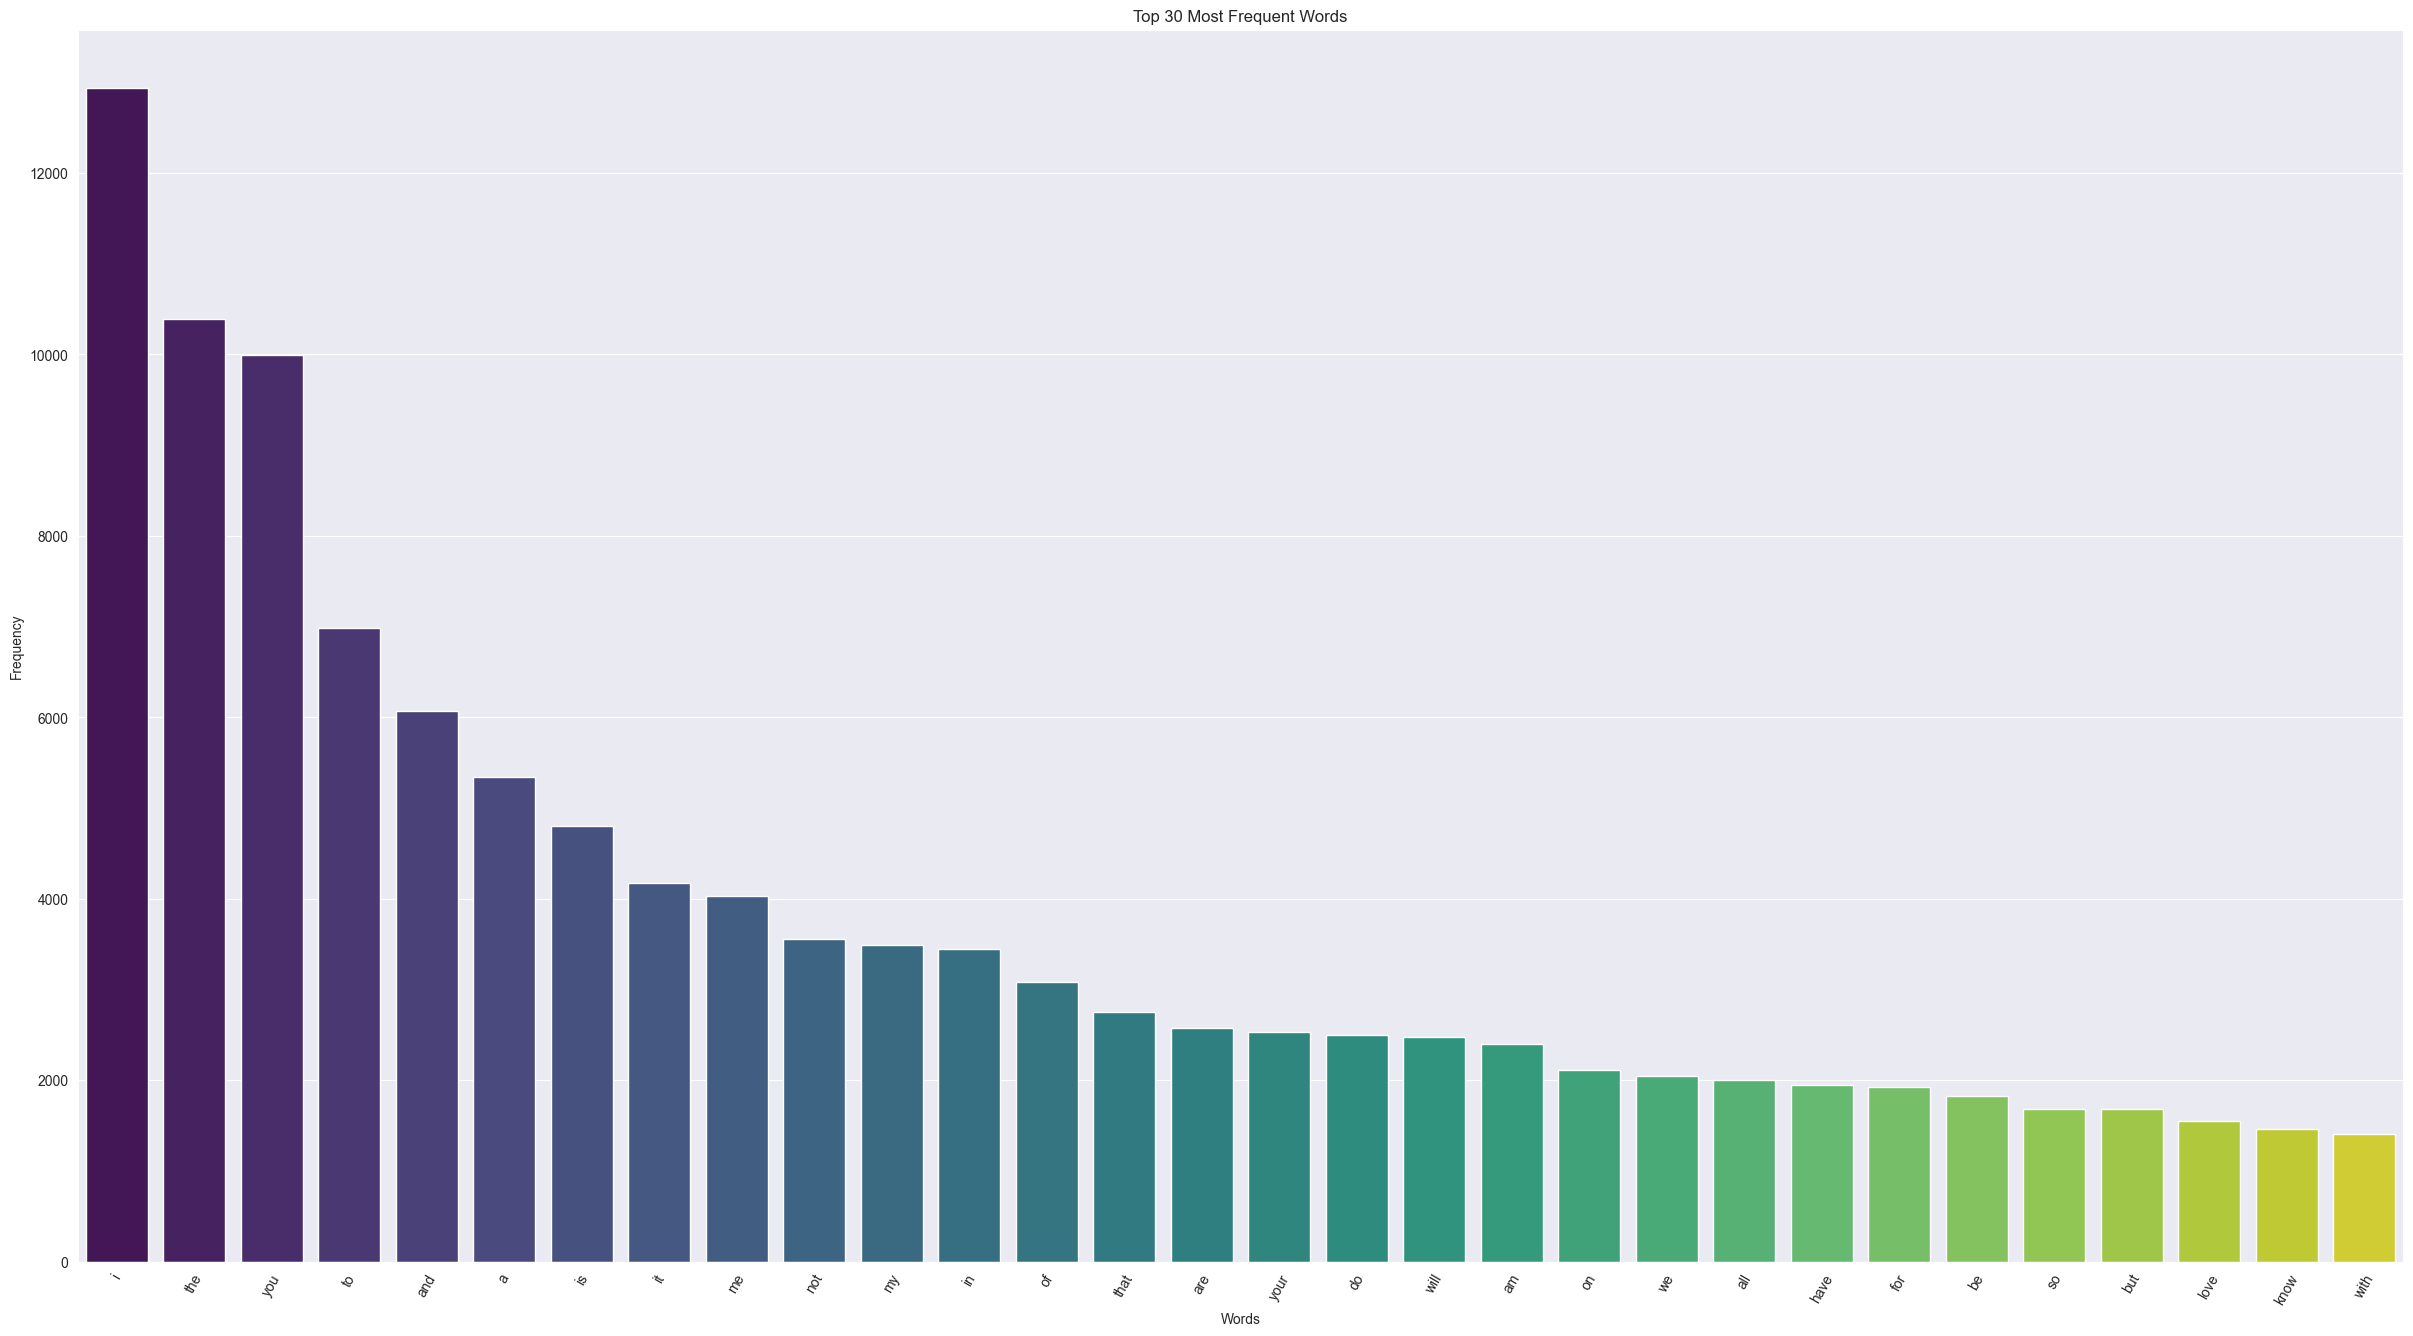

{'TTR': 0.042269477203082925, 'Total tokens': 269225, 'Unique tokens': 11380, 'Hapax Legomena': 5237, 'Dis Legomena': 1694}


In [ ]:
from wordcloud import WordCloud
from nltk.probability import FreqDist
import seaborn as sns
from collections import Counter
from nltk import pos_tag
import json
import matplotlib.pyplot as plt

# ------------------------------
# Fetch tokenized lyrics from DB
# ------------------------------
def fetch_tokenized_lyrics():
    """
    Connect to SQL Server and fetch all tokenized lyrics from the 'tokenised' column.
    Returns a flat list of all tokens from all songs.
    """
    # Connect to database
    conn = pyodbc.connect(
        r'DRIVER={ODBC Driver 17 for SQL Server};'
        r'SERVER=IVAN_PC\SQLEXPRESS;'
        r'DATABASE=TextMiningHA;'
        r'Trusted_Connection=yes;'
    )
    cursor = conn.cursor()

    # Query all non-empty tokenised lyrics
    cursor.execute("SELECT tokenised FROM songs WHERE tokenised IS NOT NULL")
    rows = cursor.fetchall()
    conn.close()

    # Flatten all token lists into a single list
    all_tokens = []
    for row in rows:
        try:
            tokens = json.loads(row[0])  # Convert JSON string to Python list
            all_tokens.extend(tokens)
        except json.JSONDecodeError:
            pass  # Skip malformed JSON entries

    return all_tokens

# ------------------------------
# Fetch cleaned tokens
# ------------------------------
def fetch_cleaned_tokens():
    """
    Connect to SQL Server and fetch DISTINCT tokens from the 'cleanTokens' column.
    Prints all unique tokens sorted alphabetically.
    """
    conn = pyodbc.connect(
        r'DRIVER={ODBC Driver 17 for SQL Server};'
        r'SERVER=IVAN_PC\SQLEXPRESS;'
        r'DATABASE=TextMiningHA;'
        r'Trusted_Connection=yes;'
    )
    cursor = conn.cursor()

    # Query all non-empty cleanTokens
    cursor.execute("SELECT cleanTokens FROM songs WHERE cleanTokens IS NOT NULL")
    rows = cursor.fetchall()
    conn.close()

    clean_tokens = set()  # Use a set to keep unique tokens
    for (cleanTokens,) in rows:
         try:
             tokens_list = json.loads(cleanTokens)
             clean_tokens.update(tokens_list)  # Add tokens to the set
         except json.JSONDecodeError:
             pass  # Skip invalid JSON entries

    # Print total number of distinct tokens and list them alphabetically
    print(f"\nTotal distinct tokens: {len(clean_tokens)}")
    print(" ".join(f"'{token}'" for token in sorted(clean_tokens, key=str)))

# ------------------------------
# Plot word cloud
# ------------------------------
def plot_wordcloud(tokens):
    """
    Generate and display a WordCloud from a list of tokens.
    """
    text_data = " ".join(tokens)  # Convert token list to a single string
    wc = WordCloud(width=900, height=650, background_color="white").generate(text_data)

    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# ------------------------------
# Plot top N word frequencies
# ------------------------------
def plot_top_word_frequencies(tokens, top_n=120):
    """
    Plot the top N most frequent words in the token list using Seaborn barplot.
    """
    freq_dist = FreqDist(tokens)
    most_common = freq_dist.most_common(top_n)

    words, counts = zip(*most_common)

    plt.figure(figsize=(30, 16))
    sns.barplot(x=list(words), y=list(counts), hue=list(words), palette="viridis", legend=False)
    plt.xticks(rotation=60)
    plt.title(f"Top {top_n} Most Frequent Words")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

# ------------------------------
# Plot POS tag distribution
# ------------------------------
def plot_pos_distribution(tokens, top_n=20):
    """
    Visualize the distribution of POS tags in the token list.
    Displays a bar plot of the most common POS tags.
    """
    tagged_tokens = pos_tag(tokens)  # Tag all tokens
    pos_tags = [tag for word, tag in tagged_tokens]  # Extract tags
    freq_dist = FreqDist(pos_tags)
    most_common = freq_dist.most_common(top_n)

    tags, counts = zip(*most_common)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(tags), y=list(counts), hue=list(tags), palette="coolwarm", legend=False)
    plt.xticks(rotation=45)
    plt.title(f"Top {top_n} POS Tag Distribution")
    plt.xlabel("POS Tags")
    plt.ylabel("Frequency")
    plt.show()

# ------------------------------
# Vocabulary diversity metrics
# ------------------------------
def vocabulary_diversity(tokens):
    """
    Compute basic vocabulary statistics:
    - TTR: Type-Token Ratio
    - Total tokens
    - Unique tokens
    - Hapax Legomena: words appearing once
    - Dis Legomena: words appearing twice
    """
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    ttr = unique_tokens / total_tokens if total_tokens else 0

    freq_dist = Counter(tokens)
    hapax_legomena = len([w for w in freq_dist if freq_dist[w] == 1])
    dis_legomena = len([w for w in freq_dist if freq_dist[w] == 2])

    return {
        "TTR": ttr,
        "Total tokens": total_tokens,
        "Unique tokens": unique_tokens,
        "Hapax Legomena": hapax_legomena,
        "Dis Legomena": dis_legomena,
    }

# ------------------------------
# POS-based vocabulary filter
# ------------------------------
def vocabulary_POS(tokens, pos_prefixes=('NN', 'VB', 'JJ')):
    """
    Keep only tokens that are nouns, verbs, or adjectives (based on POS tags).
    """
    tagged = pos_tag(tokens)
    return [word for word, tag in tagged if tag.startswith(pos_prefixes)]

# ------------------------------
# Execute analysis functions
# ------------------------------
tokens = fetch_tokenized_lyrics()            # Fetch all raw tokenized lyrics
plot_wordcloud(tokens)                       # generate word cloud
plot_top_word_frequencies(tokens, top_n=30)  # plot top 30 words
print(vocabulary_diversity(tokens))          # print vocabulary metrics
plot_pos_distribution(tokens, top_n=20)      # POS tag distribution plot
fetch_cleaned_tokens()                       # Fetch and print unique cleaned tokens


**Task 2.2: Exploratory Analysis <br> PART2**<br>This following code in the next  helped me analyze and compare the dataset before and after cleaning by visualizing token reduction with a graph. It also highlighted the exact types of tokens that were removed from the dataset, giving a clear view of how preprocessing affected the text.

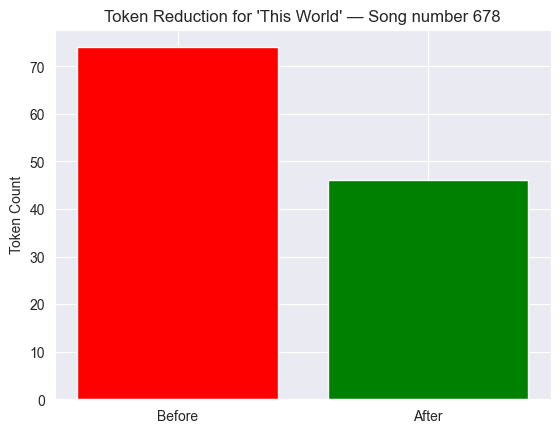

Before: 74 tokens
After: 46 tokens
Reduction: 28 tokens (37.8%)
Removed tokens: {"day's", 'we', 'in', 'are', 'have', "noah's", 'is', 'can', 'to', 'your', 'has', 'only', 'a', 'won', 'of', 'this', 'be', 'the'}

Added tokens: {'noah'}


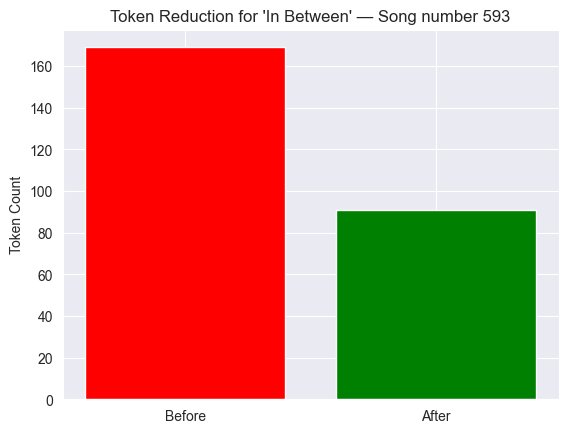

Before: 169 tokens
After: 91 tokens
Reduction: 78 tokens (46.2%)
Removed tokens: {'in', 'can', 'was', 'for', 'it', 'or', 'how', 'the', "guilt's", 'and', 'what', 'to', 'me', 'between', 'than', 'is', 'about', 'do', 'that', 'of', 'am', 'before', 'up', 'your', 'with', 'a', 'only', 'be', 'chorus'}

Added tokens: {'guilt'}


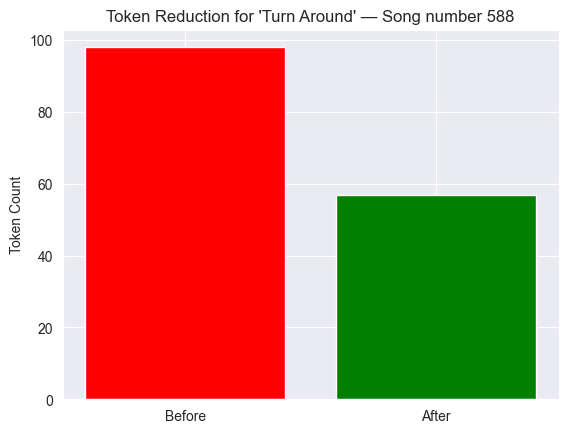

Before: 98 tokens
After: 57 tokens
Reduction: 41 tokens (41.8%)
Removed tokens: {'out', 'and', 'are', 'is', 'to', 'me', 'your', 'all', 'for', 'a', 'will', 'of', 'this', 'be', 'very', 'the'}

Added tokens: set()


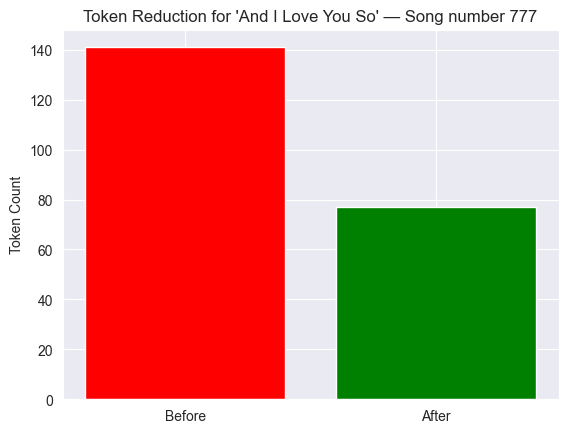

Before: 141 tokens
After: 77 tokens
Reduction: 64 tokens (45.4%)
Removed tokens: {'are', 'can', 'for', 'how', 'down', 'the', 'and', 'too', 'me', 'all', 'been', 'just', 'so', 'have', 'is', 'now', 'that', 'do', 'of', 'once', 'again', 'am', 'them', 'your', 'has', 'a', 'til', 'will', 'be'}

Added tokens: set()


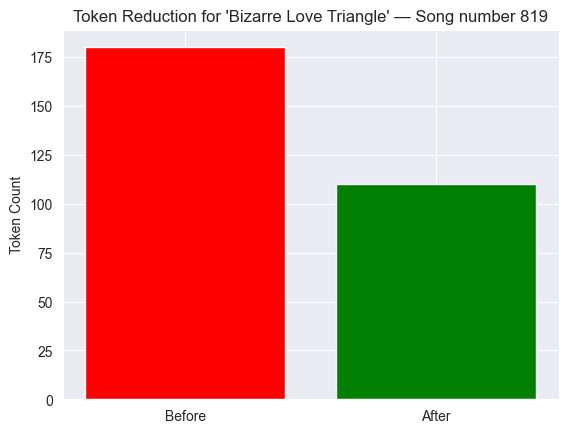

Before: 180 tokens
After: 110 tokens
Reduction: 70 tokens (38.9%)
Removed tokens: {'we', 'in', 'are', 'were', 'for', 'it', 'then', 'the', 'through', 'down', 'and', 'what', 'to', 'me', 'why', 'just', 'on', 'is', 'myself', 'that', 'do', 'of', 'am', 'ourselves', 'there', 'should', 'with', 'a', 'will', 'be', 'this'}

Added tokens: set()


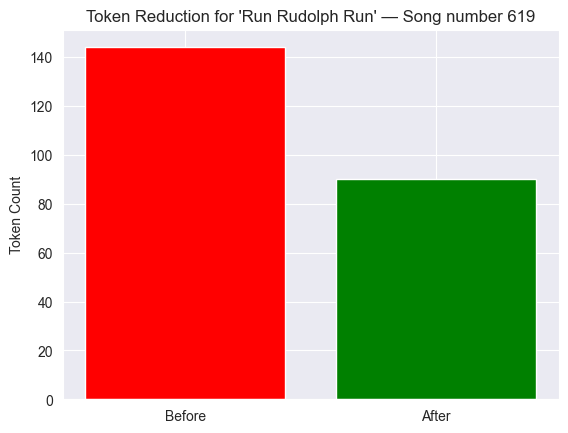

Before: 144 tokens
After: 90 tokens
Reduction: 54 tokens (37.5%)
Removed tokens: {'are', 'can', "santa's", 'for', 'it', 'then', 'down', 'the', 'and', 'too', 'what', 'to', 'all', 'been', 'him', 'on', 'have', 'is', 'because', 'that', 'of', 'am', 'go', 'out', 'a', 'most'}

Added tokens: set()


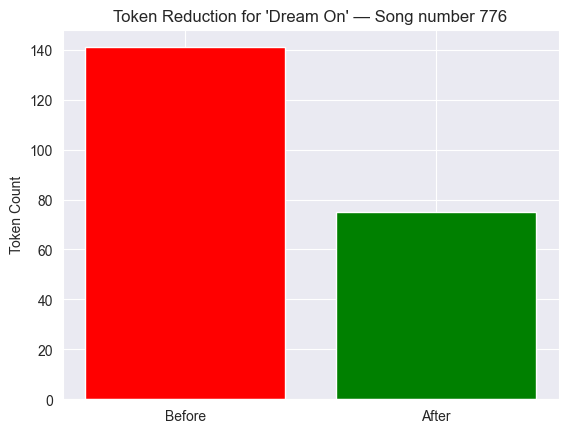

Before: 141 tokens
After: 75 tokens
Reduction: 66 tokens (46.8%)
Removed tokens: {'in', 'are', 'can', 'for', 'it', 'how', 'the', 'and', 'what', 'to', 'me', 'yourself', 'why', 'so', 'on', 'have', 'is', 'at', 'because', 'doing', 'am', 'there', 'your', 'will', 'be'}

Added tokens: set()


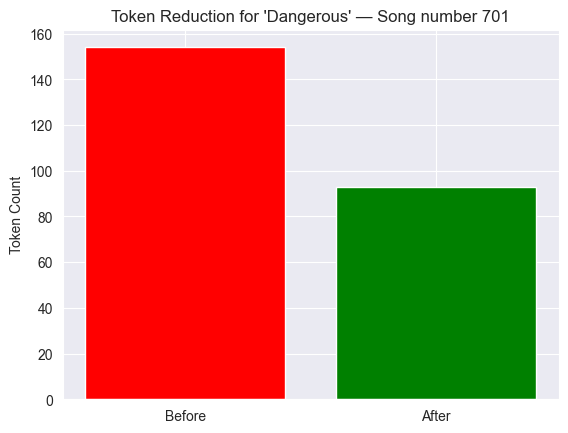

Before: 154 tokens
After: 93 tokens
Reduction: 61 tokens (39.6%)
Removed tokens: {'in', 'are', 'can', 'it', 'the', 'down', 'and', '2', 'what', 'to', 'me', 'all', 'just', 'so', 'on', 'is', 'oh', 'now', 'that', 'do', 'of', "nothing's", 'again', '1', 'where', 'your', 'a', 'chorus', 'this'}

Added tokens: {'nothing'}


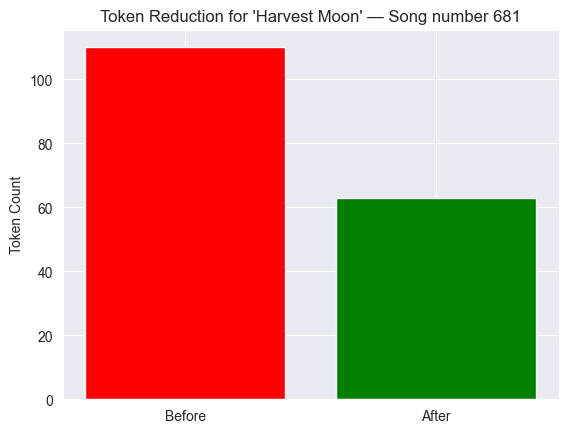

Before: 110 tokens
After: 63 tokens
Reduction: 47 tokens (42.7%)
Removed tokens: {'we', 'in', 'were', 'it', 'the', 'and', 'what', 'to', 'all', 'just', 'have', 'on', 'is', 'now', 'because', 'again', 'am', 'go', 'out', 'from', 'there', 'when', 'where', 'your', 'a', 'with', "music's", 'this'}

Added tokens: {'music'}


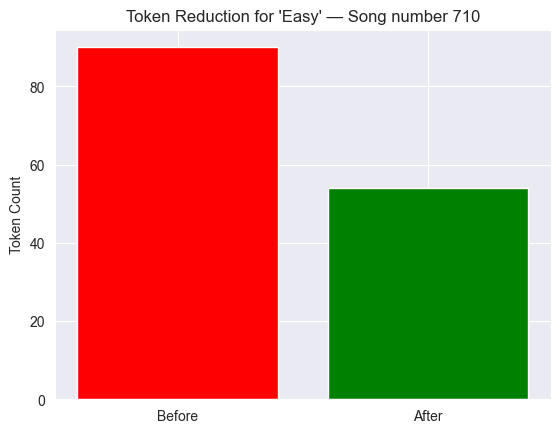

Before: 90 tokens
After: 54 tokens
Reduction: 36 tokens (40.0%)
Removed tokens: {'ooh', 'are', 'yeah', 'can', 'it', 'aah', 'the', 'and', 'to', 'me', 'all', 'why', 'just', 'so', 'have', 'ooo', 'is', 'oh', 'that', 'do', 'am', 'be'}

Added tokens: set()


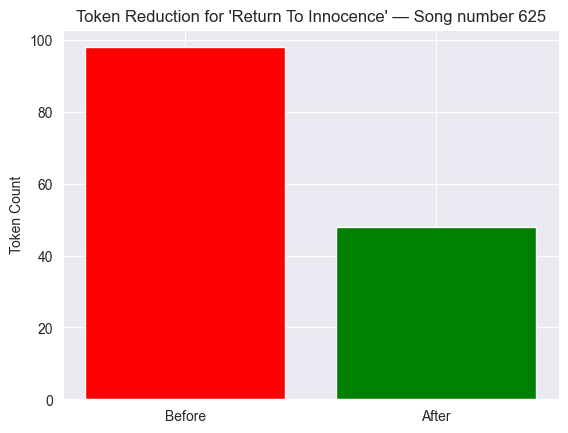

Before: 98 tokens
After: 48 tokens
Reduction: 50 tokens (51.0%)
Removed tokens: {'in', 'own', 'then', 'the', 'and', 'too', 'what', 'to', 'yourself', 'just', 'is', 'that', 'do', 'of', 'up', 'your', 'will', 'into', 'be'}

Added tokens: set()


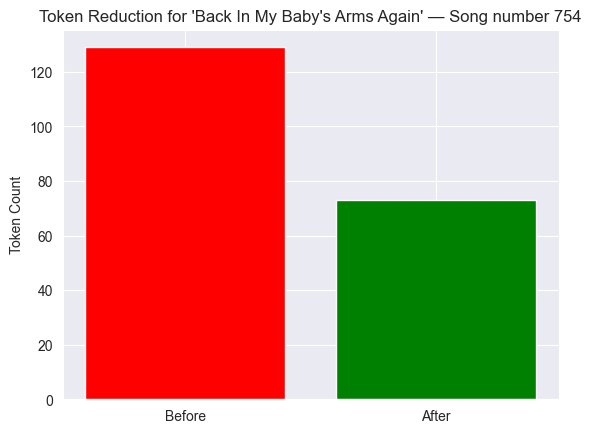

Before: 129 tokens
After: 73 tokens
Reduction: 56 tokens (43.4%)
Removed tokens: {'we', 'in', 'are', 'more', "baby's", 'the', 'and', 'to', 'is', 'oh', 'of', 'again', 'am', 'd', 'when', 'by', 'a', 'be', 'chorus'}

Added tokens: {'baby'}


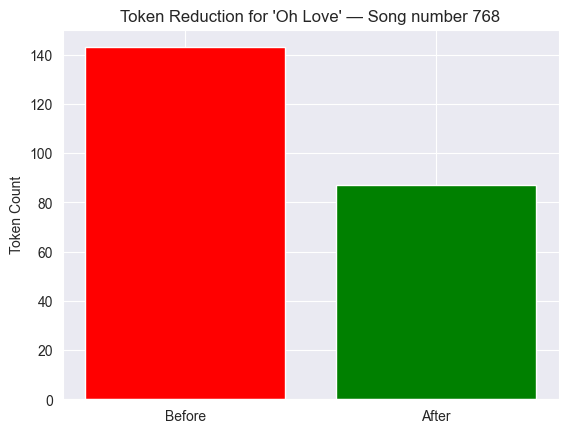

Before: 143 tokens
After: 87 tokens
Reduction: 56 tokens (39.2%)
Removed tokens: {'in', 'the', 'and', 'to', 'me', "heart's", 'just', 'on', 'oh', 'myself', 'same', 'do', 'of', 'am', 'out', 'when', 'by', 'your', 'a', 'with', 'will', 'be'}

Added tokens: set()


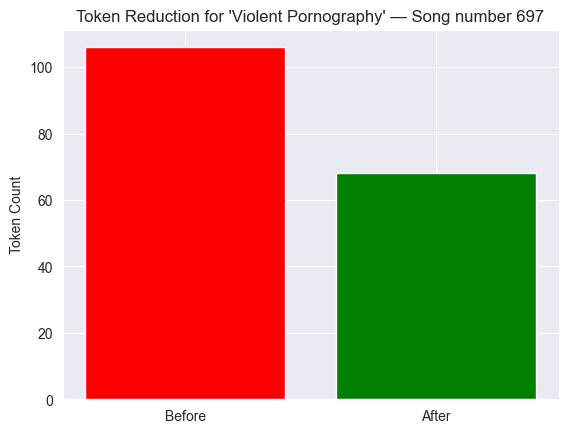

Before: 106 tokens
After: 68 tokens
Reduction: 38 tokens (35.8%)
Removed tokens: {'and', 'on', 'did', 'is', 'can', 'tv', 'your', 'now', 'a', 'off', 'that', 'of', 'it', 'the'}

Added tokens: set()


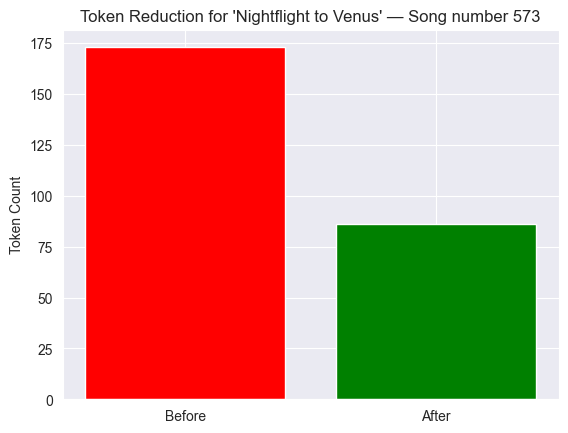

Before: 173 tokens
After: 86 tokens
Reduction: 87 tokens (50.3%)
Removed tokens: {'we', 'in', 'are', "world's", 'for', 'off', 'more', "fav'right", 'the', 'down', 'and', '2', 'to', 'few', 'all', '5', '10', '6', '8', 'm', 'on', 'have', 'is', 'at', '9', 'do', 'of', 'go', 'out', '1', 'there', '7', 'by', '2183', 'your', 'a', '3', '4', 'will', 'had', 'be', 'this'}

Added tokens: {'world'}


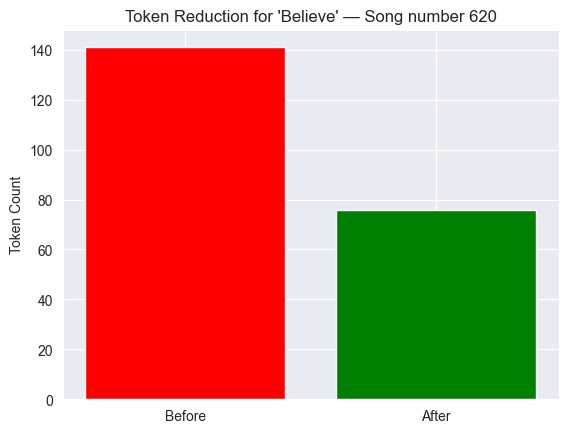

Before: 141 tokens
After: 76 tokens
Reduction: 65 tokens (46.1%)
Removed tokens: {'we', 'in', 'are', 'were', 'it', 'their', 'the', 'and', 'what', 'to', 'all', 'just', 'so', 'on', 'have', 'is', 'that', 'again', 'go', 'ourselves', 'there', 'when', 'where', 'by', 'your', 'up', "journey's", 'had', 'be'}

Added tokens: {'journey'}


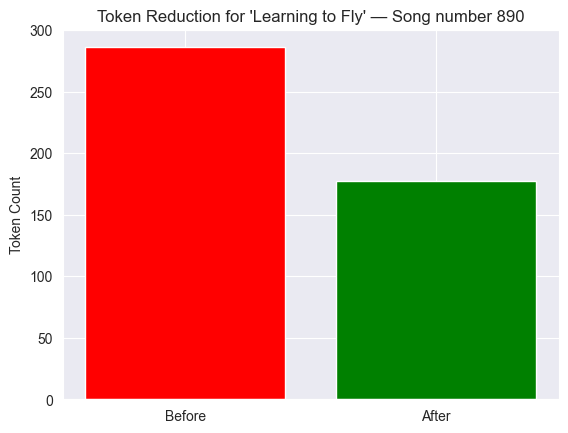

Before: 286 tokens
After: 177 tokens
Reduction: 109 tokens (38.1%)
Removed tokens: {'in', 'can', 'for', '129', 'over', 'it', 'how', 'the', 'through', 'and', 'to', 'me', '10', 'just', '8', 'on', 'is', 'now', 'that', 'of', 'an', 'again', 'both', 'go', 'out', 'from', 'there', 'above', 'by', 'your', 'a', 'with', '3', '4', 'into', 'this'}

Added tokens: set()


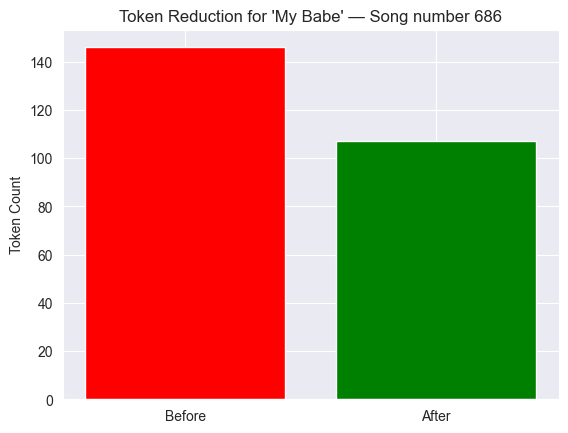

Before: 146 tokens
After: 107 tokens
Reduction: 39 tokens (26.7%)
Removed tokens: {'so', 'and', 'are', 'when', 'there', 'is', 'yeah', "ev'rything", 'me', 'oh', 'that', 'do', 'of'}

Added tokens: set()


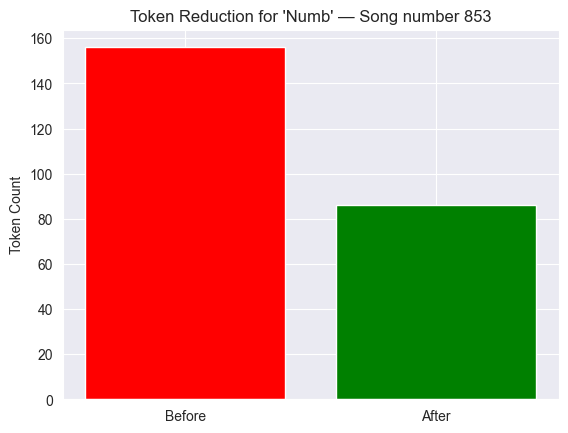

Before: 156 tokens
After: 86 tokens
Reduction: 70 tokens (44.9%)
Removed tokens: {'in', 'are', 'were', 'can', 'more', 'the', 'and', 'too', 'what', 'to', 'me', 'all', 'just', 'so', 'than', 'have', 'is', 'because', 'that', 'do', 'of', 'being', 'am', 'there', 'by', 'up', 'your', 'has', 'with', 'under', 'be', 'chorus', 'this'}

Added tokens: set()


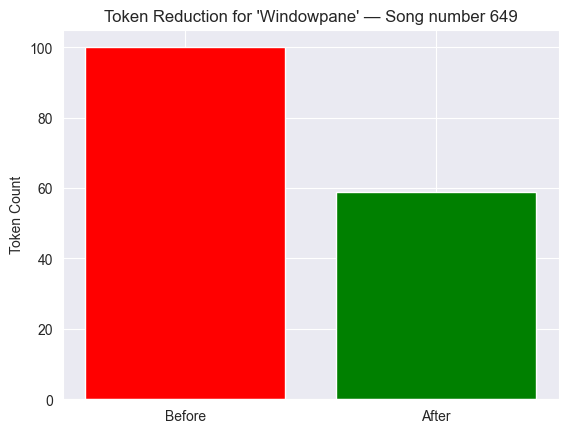

Before: 100 tokens
After: 59 tokens
Reduction: 41 tokens (41.0%)
Removed tokens: {'in', 'for', 'over', 'or', 'the', 'and', 'to', 'me', 'all', 'on', 'at', 'is', 'of', 'again', 'there', 'a', 'with', 'his', 'be'}

Added tokens: set()


In [7]:
import random
import pyodbc
import pandas as pd
import ast
import matplotlib.pyplot as plt
import datacompy
from sqlalchemy import create_engine


def analyze_row(row_number):
    """
    Fetch a specific row from the 'songs' table by its row offset,
    compare token counts before and after cleaning, and visualize the change.

    Parameters:
        row_number (int): 0-based offset of the row to fetch from the database.
    """
    # --- Database connection ---
    # Use SQLAlchemy engine for querying SQL Server
    engine = create_engine(
        "mssql+pyodbc://IVAN_PC\\SQLEXPRESS/TextMiningHA?driver=ODBC+Driver+17+for+SQL+Server"
    )

    # --- Query to fetch one row by offset ---
    query = f"""
    SELECT song_id, name, tokenised, cleanTokens
    FROM songs
    ORDER BY song_id
    OFFSET {row_number} ROWS FETCH NEXT 1 ROWS ONLY
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    # If no row found, stop execution
    if df.empty:
        print(f"No row found for offset {row_number}")
        return

    # --- Convert JSON-like strings back to Python lists ---
    df['tokenised'] = df['tokenised'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['cleanTokens'] = df['cleanTokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # --- Count tokens before and after cleaning ---
    before_count = len(df['tokenised'][0])
    after_count = len(df['cleanTokens'][0])

    # --- Visualization: bar chart of reduction ---
    plt.bar(['Before', 'After'], [before_count, after_count], color=['red', 'green'])
    plt.ylabel('Token Count')
    plt.title(f"Token Reduction for '{df['name'][0]}' — Song number {row_number + 1}")
    plt.show()

    # --- Print summary statistics ---
    print(f"Before: {before_count} tokens")
    print(f"After: {after_count} tokens")
    print(f"Reduction: {before_count - after_count} tokens "
          f"({(before_count - after_count) / before_count * 100:.1f}%)")

    # --- Prepare DataFrames for comparison ---
    # Add artificial index to preserve token order
    before_df = pd.DataFrame({'token': df['tokenised'][0]})
    before_df['idx'] = before_df.index

    after_df = pd.DataFrame({'token': df['cleanTokens'][0]})
    after_df['idx'] = after_df.index

    # --- Compare before vs after using datacompy ---
    compare = datacompy.Compare(
        before_df,
        after_df,
        join_columns=['idx'],       # Align on artificial index
        df1_name='Before Cleaning',
        df2_name='After Cleaning'
    )
    # Optional: uncomment for full report
    # print(compare.report())

    # --- Show which tokens were removed/added ---
    removed = set(df['tokenised'][0]) - set(df['cleanTokens'][0])
    added = set(df['cleanTokens'][0]) - set(df['tokenised'][0])

    print(f"Removed tokens: {removed}\n")
    print(f"Added tokens: {added}")


# --- Run analysis on 20 random songs ---
# Pick 20 random row offsets between 1 and 100 (change range as needed)
random_rows = random.sample(range(560, 900), 20)
for row in random_rows:
    analyze_row(row)


**Final Thoughts:** My best tool for preparing tokens for TF-IDF was the **"clean_lyrics_tokens(1,1600, show_output=0)"** function located in Line160 in the first cell. It allowed me to carefully reduce noise without aggressively cutting down the token set, maintaining a balance between token quantity and semantic richness. Using this function helped me refine my regex patterns and preprocessing steps.<br>A typical output shows the song number and name, the original lyrics, the raw tokens extracted from tokenization, and the polished tokens after applying regex rules and removing stopwords, numbers, and repeated characters. This process ensures that meaningful words are retained while noise is eliminated, producing a balanced token set suitable for TF-IDF and other NLP analyses.



--- Song 1: How Can You Mend A Broken Heart ---
Original lyrics:
I can think of younger days when living for my life    Was everything a man could want to do    I could never see tomorrow,    But I was never told about the sorrow        And how can you mend a broken heart?    How can you stop the rain from falling down?    How can you stop the sun from shining?    What makes the world go round?    How can you mend this broken man?    How can a loser ever win?    Please help me mend my broken heart and let me live again        I can still feel the breeze that rustles through the trees    And misty memories of days gone by    We could never see tomorrow,    No one said a word about the sorrow        And how can you mend a broken heart?    How can you stop the rain from falling down?    How can you stop the sun from shining?    What makes the world go round?    And how can you mend this broken man?    How can a loser ever win?    Please help me mend my broken heart and let me live again        La la la la la la, la la la la    La la la la la la, la la la la        Please help me mend my broken heart and let me live again        Da da da da    Da da da da, da da da da da, da

Tokenized lyrics:
['i', 'can', 'think', 'of', 'younger', 'days', 'when', 'living', 'for', 'my', 'life', 'be', 'everything', 'a', 'man', 'could', 'want', 'to', 'do', 'i', 'could', 'never', 'see', 'tomorrow', 'but', 'i', 'be', 'never', 'told', 'about', 'the', 'sorrow', 'and', 'how', 'can', 'you', 'mend', 'a', 'broken', 'heart', 'how', 'can', 'you', 'stop', 'the', 'rain', 'from', 'falling', 'down', 'how', 'can', 'you', 'stop', 'the', 'sun', 'from', 'shining', 'what', 'makes', 'the', 'world', 'go', 'round', 'how', 'can', 'you', 'mend', 'this', 'broken', 'man', 'how', 'can', 'a', 'loser', 'ever', 'win', 'please', 'help', 'me', 'mend', 'my', 'broken', 'heart', 'and', 'let', 'me', 'live', 'again', 'i', 'can', 'still', 'feel', 'the', 'breeze', 'that', 'rustles', 'through', 'the', 'trees', 'and', 'misty', 'memories', 'of', 'days', 'gone', 'by', 'we', 'could', 'never', 'see', 'tomorrow', 'no', 'one', 'said', 'a', 'word', 'about', 'the', 'sorrow', 'and', 'how', 'can', 'you', 'mend', 'this', 'broken', 'man', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da', 'da']

----------------------------------------------------------------------------------------------------

Polished tokens:
['i', 'think', 'younger', 'days', 'living', 'my', 'life', 'everything', 'man', 'could', 'want', 'i', 'could', 'never', 'see', 'tomorrow', 'but', 'i', 'never', 'told', 'sorrow', 'you', 'mend', 'broken', 'heart', 'you', 'stop', 'rain', 'falling', 'you', 'stop', 'sun', 'shining', 'makes', 'world', 'round', 'you', 'mend', 'broken', 'man', 'loser', 'ever', 'win', 'please', 'help', 'mend', 'my', 'broken', 'heart', 'let', 'live', 'i', 'still', 'feel', 'breeze', 'rustles', 'trees', 'misty', 'memories', 'days', 'gone', 'could', 'never', 'see', 'tomorrow', 'no', 'one', 'said', 'word', 'sorrow', 'you', 'mend', 'broken', 'man']

...................................................................................................................................................